In [ ]:
%load_ext autoreload
%autoreload 2

: 

In [3]:
%cd ..

/home/s0001900/dev/nerf-thesis


/home/s0001900/dev/nerf-thesis/venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [4]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import transforms3d as t3d
import matplotlib.colors as colors

import torch
from transformers import AutoImageProcessor, AutoModelForDepthEstimation


from src.data import LidarDataGetter, PandasetInfoGetter, SampleInfo, IntrinsicsDataGetter, PoseDataGetter, RGBDataGetter

In [5]:
data_config = {
  "dataset": "pandaset",
  "path": "/home/s0001900/dev/datasets/pandaset",
  "data_getters": {
    "rgb": {
      "camera": "front_camera",
      "height": 1080,
      "width": 1920
    },
    "lidar": {
        "height": 1080,
        "width": 1920
    },
    "meta": {}
  },
  "data_tree": {
    "pandaset": {
      "001": ["01"]
    }
  }
}

data_config

{'dataset': 'pandaset',
 'path': '/home/s0001900/dev/datasets/pandaset',
 'data_getters': {'rgb': {'camera': 'front_camera',
   'height': 1080,
   'width': 1920},
  'lidar': {'height': 1080, 'width': 1920},
  'meta': {}},
 'data_tree': {'pandaset': {'001': ['01']}}}

## Lidar

In [8]:

info_getter = PandasetInfoGetter()
rgb_getter = RGBDataGetter(info_getter, {})
lidar_getter = LidarDataGetter(info_getter, {})
intrinsics_getter = IntrinsicsDataGetter(info_getter, {})
pose_getter = PoseDataGetter(info_getter, {})

data_path = Path(data_config["path"])
sample_info = SampleInfo("pandaset", "001", "02")

ex_rgb = rgb_getter.get_data(data_path, sample_info)
ex_lidar =  lidar_getter.get_data(data_path, sample_info)
ex_intr = intrinsics_getter.get_data(data_path, sample_info)
ex_pose = pose_getter.get_data(data_path, sample_info)
lidar_pts = ex_lidar.to_numpy()[..., :3]

In [9]:

def _heading_position_to_mat(heading, position):
    quat = np.array([heading["w"], heading["x"], heading["y"], heading["z"]])
    pos = np.array([position["x"], position["y"], position["z"]])
    transform_matrix = t3d.affines.compose(np.array(pos),
                                           t3d.quaternions.quat2mat(quat),
                                           [1.0, 1.0, 1.0])
    return transform_matrix



def projection(lidar_points, image_w, image_h, camera_pose_mat, camera_intrinsics, filter_outliers=True):
    trans_lidar_to_camera = np.linalg.inv(camera_pose_mat)
    points3d_lidar = lidar_points
    points3d_camera = trans_lidar_to_camera[:3, :3] @ (points3d_lidar.T) + \
                        trans_lidar_to_camera[:3, 3].reshape(3, 1)

    inliner_indices_arr = np.arange(points3d_camera.shape[1])
    if filter_outliers:
        condition = points3d_camera[2, :] > 0.0
        points3d_camera = points3d_camera[:, condition]
        inliner_indices_arr = inliner_indices_arr[condition]

    K = np.eye(3, dtype=np.float64)
    K[0, 0] = camera_intrinsics["fx"]
    K[1, 1] = camera_intrinsics["fy"]
    K[0, 2] = camera_intrinsics["cx"]
    K[1, 2] = camera_intrinsics["cy"]
    points2d_camera = K @ points3d_camera
    points2d_camera = (points2d_camera[:2, :] / points2d_camera[2, :]).T

    if filter_outliers:
        condition = np.logical_and(
            (points2d_camera[:, 1] < image_h) & (points2d_camera[:, 1] > 0),
            (points2d_camera[:, 0] < image_w) & (points2d_camera[:, 0] > 0))
        points2d_camera = points2d_camera[condition]
        points3d_camera = (points3d_camera.T)[condition]
        inliner_indices_arr = inliner_indices_arr[condition]

    return points2d_camera, points3d_camera, inliner_indices_arr


camera_pose_mat = _heading_position_to_mat(ex_pose["heading"], ex_pose["position"])
points2d_camera, points3d_camera, inliner_indices_arr = projection(lidar_pts, 1920, 1080, camera_pose_mat, ex_intr)

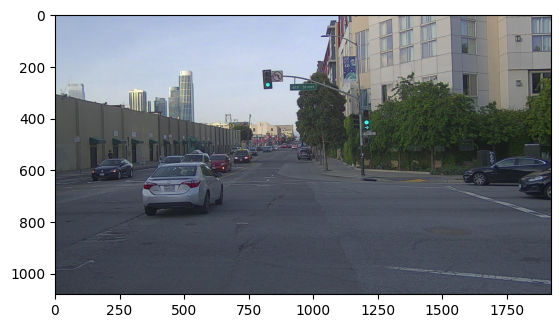

In [18]:


plt.imshow(ex_rgb.permute(1, 2, 0))

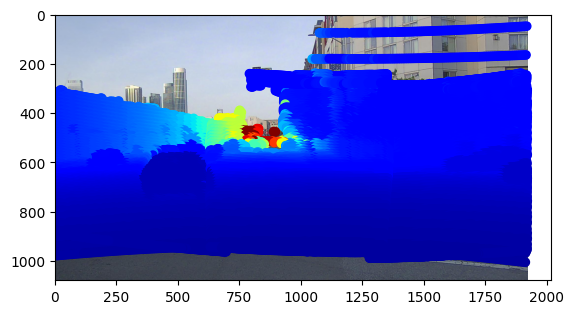

In [19]:
plt.imshow(ex_rgb.permute(1, 2, 0))
dists = np.sqrt(np.sum(np.square(points3d_camera), axis=-1))
plt.scatter(points2d_camera[:, 0], points2d_camera[:, 1], c=cm.jet(dists / dists.max()))

## DepthAnything

In [20]:
depth_image_processor = AutoImageProcessor.from_pretrained("LiheYoung/depth-anything-small-hf")
depth_model = AutoModelForDepthEstimation.from_pretrained("LiheYoung/depth-anything-small-hf")

In [21]:
inputs = depth_image_processor(images=ex_rgb, return_tensors="pt", do_rescale=False)

with torch.no_grad():
    dep_outputs = depth_model(**inputs)
    pred_dep = dep_outputs.predicted_depth
    

In [22]:
pred_dep_sized = torch.nn.functional.interpolate(
    pred_dep.unsqueeze(1),
    size=ex_rgb.shape[1:],
    align_corners=False,
    mode="bicubic"
)[0]


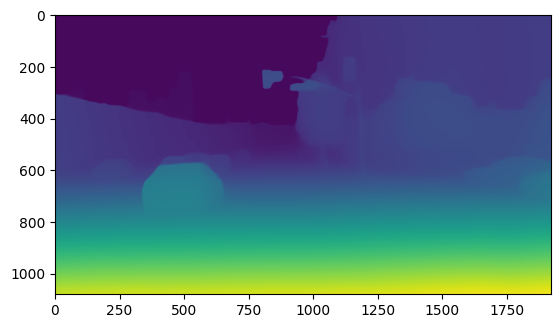

In [23]:
plt.imshow(pred_dep_sized.permute(1, 2, 0) / pred_dep_sized.max())

In [24]:
pred_dep_2 = torch.clone(pred_dep_sized)
dists_2 = dists.copy()
#dists_2[(dists_2 < 0) | (dists_2 > 50)] = -1   # Filter
for i, (x, y) in enumerate(points2d_camera):
    if dists_2[i] < 0:
        continue

    pred_dep_2[0, int(y), int(x)] = dists_2[i] 

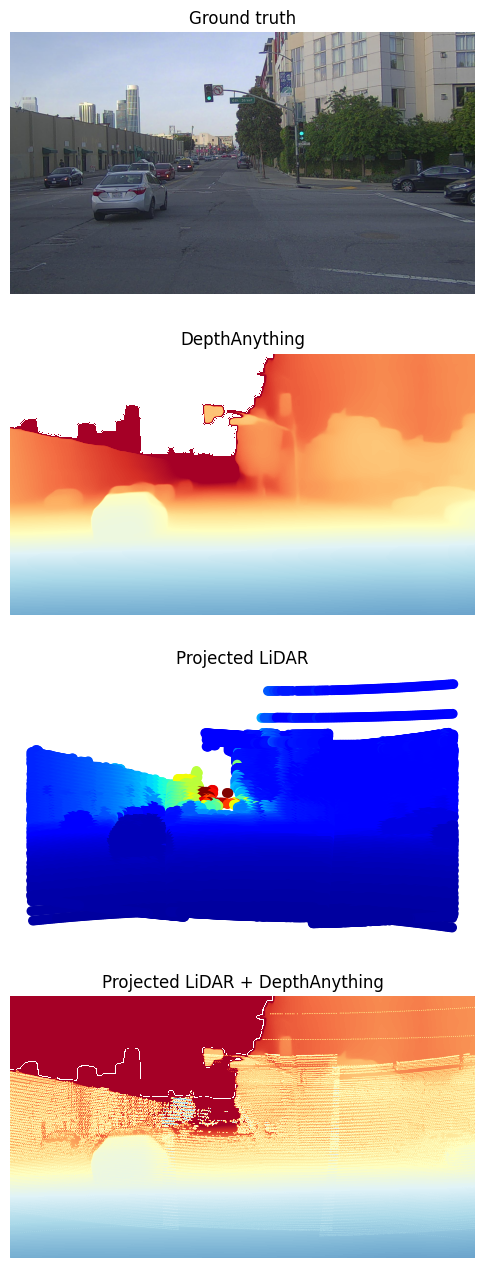

In [40]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(4, 1, figsize=(6, 16))
VMIN = 2
VMAX = 50
CMAP = 'RdYlBu'

ax0.imshow(ex_rgb.permute(1, 2, 0))
ax0.set_title("Ground truth")
ax0.set_axis_off()
ax1.imshow(pred_dep_sized.permute(1, 2, 0),  norm=colors.LogNorm(vmin=VMIN, vmax=VMAX, clip=False), cmap=CMAP)
ax1.set_title("DepthAnything")
ax1.set_axis_off()
ax2.scatter(points2d_camera[:, 0], points2d_camera[:, 1], c=cm.jet(dists / dists.max()))
ax2.invert_yaxis()
ax2.set_title("Projected LiDAR")
ax2.set_axis_off()
ax3.imshow(pred_dep_2.permute(1, 2, 0),  norm=colors.LogNorm(vmin=VMIN, vmax=VMAX, clip=False), cmap=CMAP)
ax3.set_title("Projected LiDAR + DepthAnything")
ax3.set_axis_off()

(-0.5, 1919.5, 1079.5, -0.5)

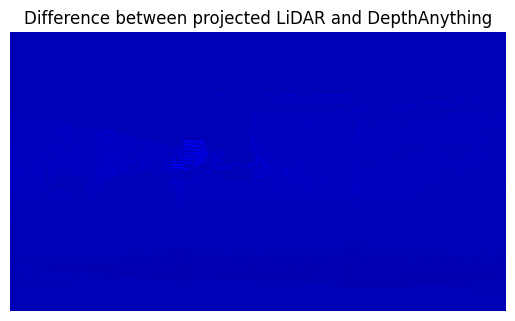

In [53]:
dmap = pred_dep_2 - pred_dep_sized
plt.imshow(dmap.permute(1, 2, 0), cmap="jet")
plt.title("Difference between projected LiDAR and DepthAnything")
plt.axis("off")

In [49]:
dmap.min(), dmap.max(), dmap.mean(), dmap.std()

(tensor(-303.3736), tensor(15.3056), tensor(-0.7013), tensor(6.3193))

Text(0, 0.5, 'Number of pixels')

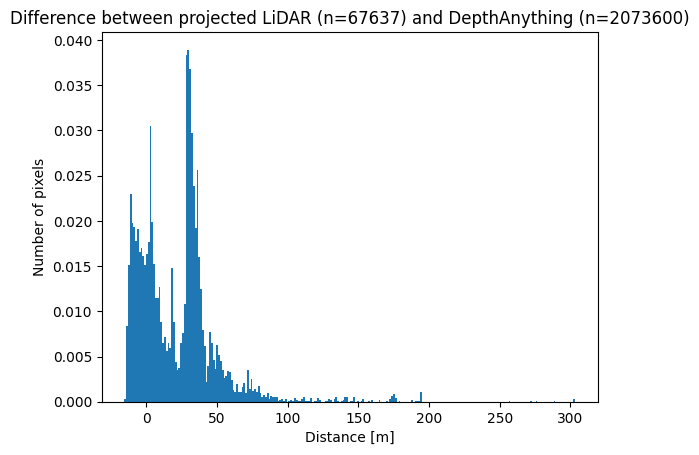

In [63]:
plt.hist(dmap[dmap!=0].flatten(), bins=250, density=True);
plt.title(f"Difference between projected LiDAR (n={len(inliner_indices_arr)}) and DepthAnything (n={dmap.shape[1]*dmap.shape[2]})")
plt.xlabel(f"Distance [m]")
plt.ylabel(f"Number of pixels")

## ControlNet

In [204]:
from diffusers import StableDiffusionControlNetImg2ImgPipeline, ControlNetModel, UniPCMultistepScheduler

controlnet = ControlNetModel.from_pretrained("lllyasviel/control_v11f1p_sd15_depth", torch_dtype=torch.float16, use_safetensors=True)
pipe = StableDiffusionControlNetImg2ImgPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnet, torch_dtype=torch.float16, use_safetensors=True
)

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe.enable_model_cpu_offload()

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [205]:
depth_image_processor = AutoImageProcessor.from_pretrained("LiheYoung/depth-anything-small-hf")
depth_model = AutoModelForDepthEstimation.from_pretrained("LiheYoung/depth-anything-small-hf")


In [207]:
with torch.no_grad():
    ex_rgb_proc = depth_image_processor(images=ex_rgb, return_tensors="pt", do_rescale=False)
    ex_dep = depth_model(**ex_rgb_proc)
    pred_dep = torch.nn.functional.interpolate(
        ex_dep.predicted_depth.unsqueeze(1),
        size=ex_rgb.shape[1:],
        align_corners=False,
        mode="bicubic"
    )[0]


In [210]:
pred_dep

tensor([[[ 0.0000,  0.0000,  0.0000,  ...,  4.2641,  3.6415,  3.2821],
         [ 0.0000,  0.0000,  0.0000,  ...,  4.3324,  3.8974,  3.6463],
         [ 0.0000,  0.0000,  0.0000,  ...,  4.4502,  4.3409,  4.2776],
         ...,
         [24.6699, 24.8983, 25.2882,  ..., 27.6970, 27.3792, 27.2033],
         [22.8238, 23.5229, 24.7208,  ..., 27.4596, 26.4282, 25.8427],
         [21.7583, 22.7291, 24.3933,  ..., 27.3274, 25.8844, 25.0628]]])

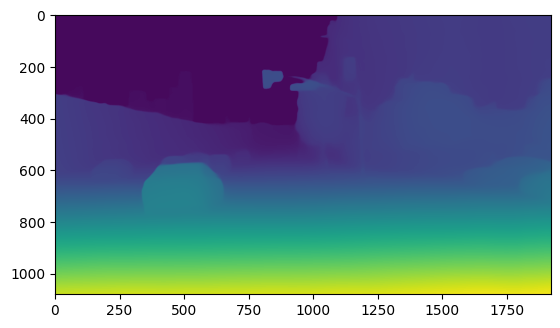

In [208]:
plt.imshow(pred_dep.permute(1, 2, 0))

In [235]:
import torchvision.transforms.v2 as tv2

downsampling_factor = 2
new_size = tuple(s // downsampling_factor for s in ex_rgb.shape[1:]) 

input_rgb = tv2.functional.resize(ex_rgb[None, ...], new_size)
input_dep = tv2.functional.resize(pred_dep.repeat(3, 1, 1)[None, ...], new_size)

(540, 960)


In [253]:
pipe.unload_lora_weights()
output_rgb = pipe(prompt="", image=input_rgb, control_image=input_dep, strength=0.4)

  0%|          | 0/20 [00:00<?, ?it/s]

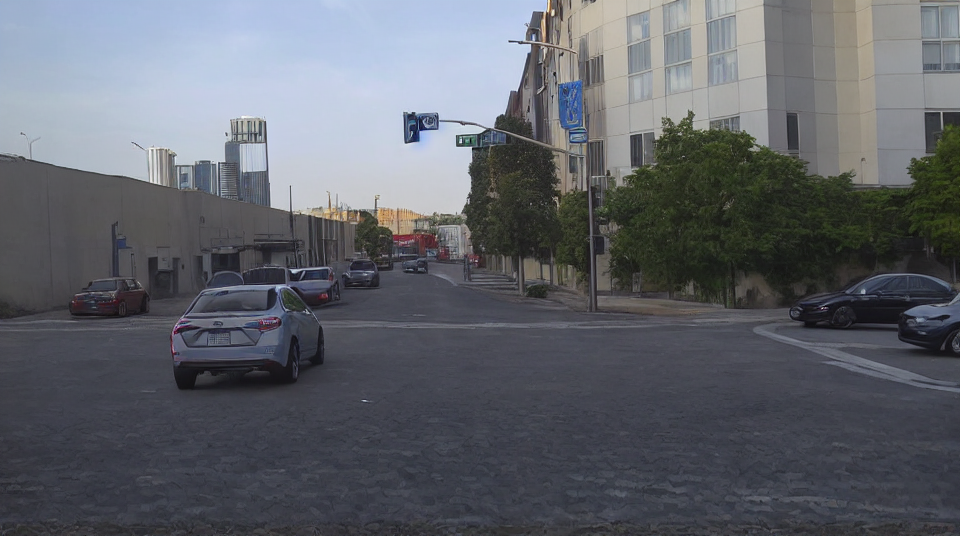

In [254]:
output_rgb.images[0]

In [255]:
pipe.load_lora_weights("/home/s0001900/dev/pytorch_lora_weights_v1.safetensors")

In [256]:
output_rgb_lora = pipe(prompt="", image=input_rgb, control_image=input_dep, strength=0.4)

  0%|          | 0/20 [00:00<?, ?it/s]

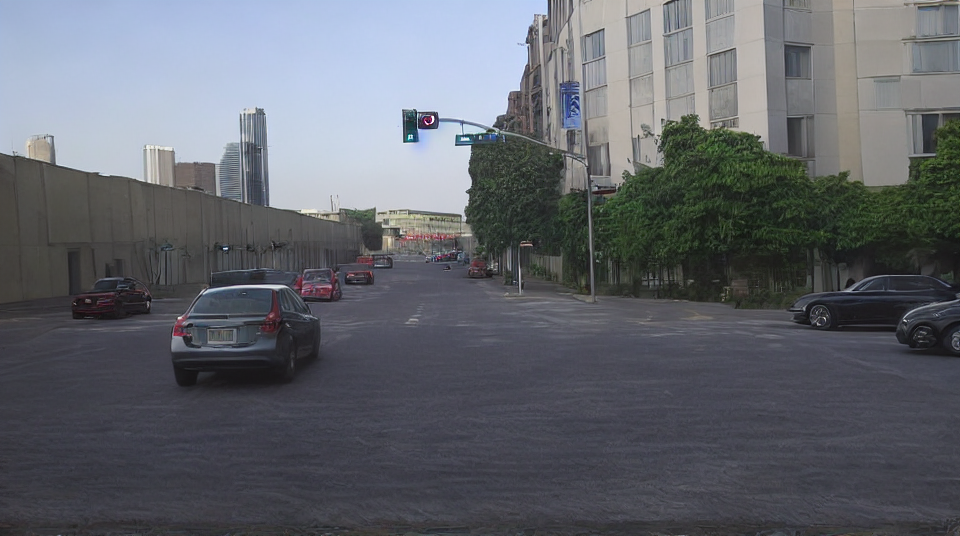

In [257]:
output_rgb_lora.images[0]